In [51]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_theme()

# Netflix Shows Analysis Project

## About the Dataset
This analysis explores the Netflix Shows dataset from Kaggle, which contains detailed information about movies and TV shows available on Netflix's streaming platform.

### Dataset Source
[Netflix Movies and TV Shows](https://www.kaggle.com/datasets/shivamb/netflix-shows)

### Column Descriptions
- show_id: Unique identifier for each show/movie
- type: Content type (Movie or TV Show)
- title: Title of the content
- director: Director(s) of the content
- cast: List of actors
- country: Country of production
- date_added: Date when added to Netflix
- release_year: Year of release
- rating: Content rating (e.g., TV-MA, PG-13)
- duration: Content duration (minutes for movies, seasons for TV shows)
- listed_in: Genre categories
- description: Brief synopsis of the content

### Dataset Relevance
This dataset is particularly suitable for analysis because:
1. It contains both categorical and numerical data
2. It offers multiple angles for analysis (temporal, geographical, content-based)
3. It includes features that can be used for meaningful regression analysis

In [54]:
# Load and Display Initial Data
df = pd.read_csv('data.csv')

# Basic dataset information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

Dataset Shape: (8807, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Missing values in each column:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating     

## Data Cleaning & Preprocessing

The following steps will be taken to clean and prepare the data:
1. Handle missing values
2. Convert date formats
3. Extract numerical values from duration
4. Create additional features for analysis

In [57]:
def preprocess_data(df):
    """
    Comprehensive data preprocessing function
    """
    # Create a copy of the dataframe
    df_clean = df.copy()
    
    # Clean date_added column by removing extra spaces and converting to datetime
    df_clean['date_added'] = df_clean['date_added'].str.strip()  # Remove leading/trailing spaces
    df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], format='mixed')
    
    # Handle missing values
    df_clean['director'].fillna('Unknown Director', inplace=True)
    df_clean['cast'].fillna('Unknown Cast', inplace=True)
    df_clean['country'].fillna('Unknown Country', inplace=True)
    df_clean['rating'].fillna(df_clean['rating'].mode()[0], inplace=True)
    
    # Extract numerical duration
    df_clean['duration_num'] = df_clean['duration'].str.extract('(\d+)').astype(float)
    
    # Create additional features
    df_clean['added_year'] = df_clean['date_added'].dt.year
    df_clean['added_month'] = df_clean['date_added'].dt.month
    
    return df_clean

# Apply preprocessing
df_clean = preprocess_data(df)

# Verify preprocessing results
print("Missing values after preprocessing:")
print(df_clean.isnull().sum())

# Display the first few rows to verify the date conversion
print("\nFirst few rows after preprocessing:")
print(df_clean[['date_added', 'added_year', 'added_month']].head())

Missing values after preprocessing:
show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      10
release_year     0
rating           0
duration         3
listed_in        0
description      0
duration_num     3
added_year      10
added_month     10
dtype: int64

First few rows after preprocessing:
  date_added  added_year  added_month
0 2021-09-25      2021.0          9.0
1 2021-09-24      2021.0          9.0
2 2021-09-24      2021.0          9.0
3 2021-09-24      2021.0          9.0
4 2021-09-24      2021.0          9.0


## Exploratory Data Analysis (EDA)

### 1. Data Distributions

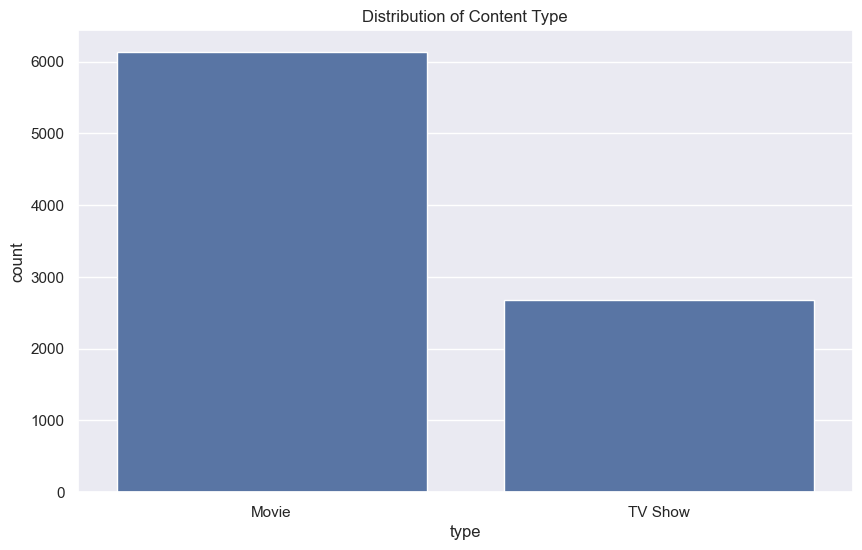

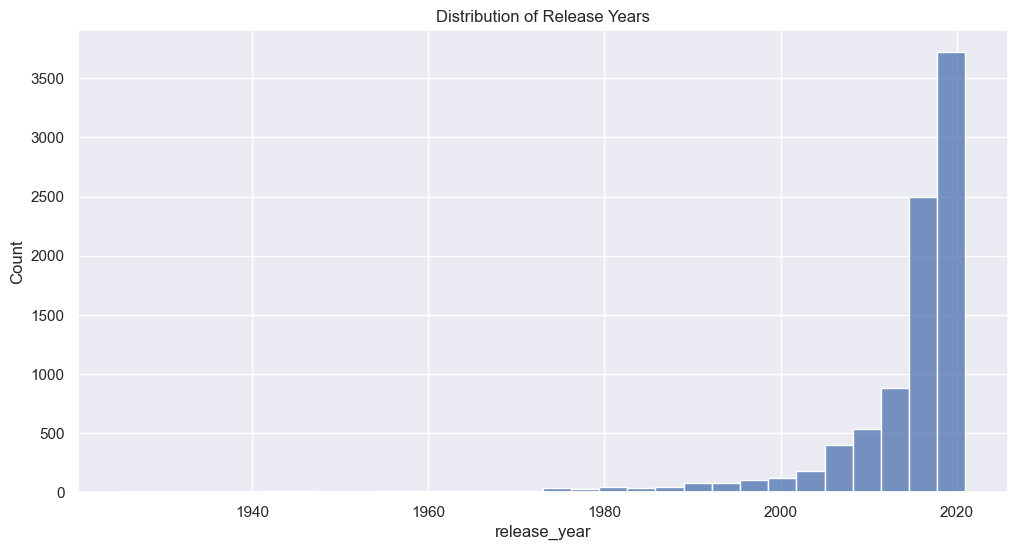

In [60]:
# Content Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='type')
plt.title('Distribution of Content Type')
plt.show()

# Release Year Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='release_year', bins=30)
plt.title('Distribution of Release Years')
plt.show()

### 2. Outlier Analysis


Outlier Analysis for release_year:


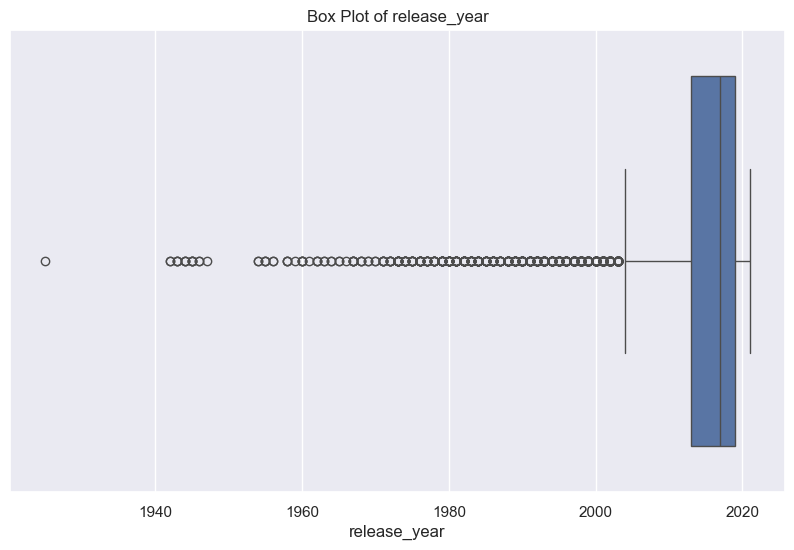

Number of outliers: 719

Outlier Analysis for duration_num:


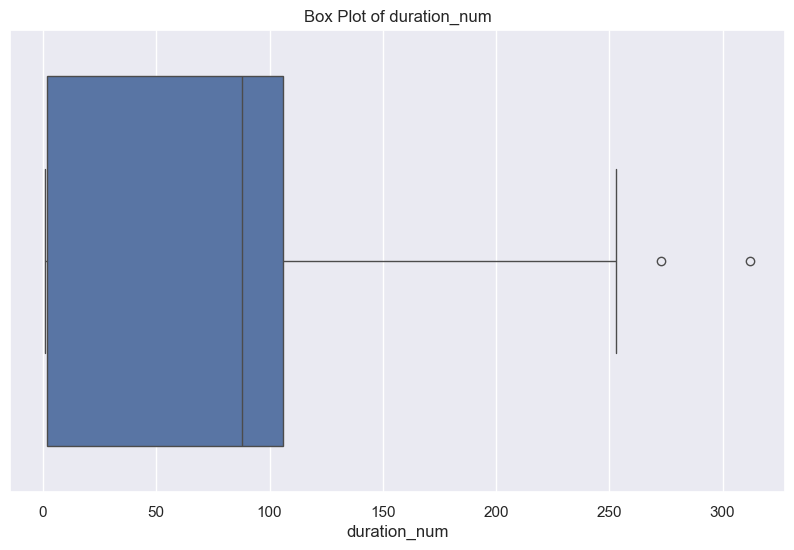

Number of outliers: 2


In [62]:
# Function to detect and visualize outliers
def analyze_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Create box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()
    
    return outliers

# Analyze outliers in numerical columns
numerical_columns = ['release_year', 'duration_num']
for col in numerical_columns:
    print(f"\nOutlier Analysis for {col}:")
    outliers = analyze_outliers(df_clean, col)
    print(f"Number of outliers: {len(outliers)}")

### 3. Relationships Between Variables

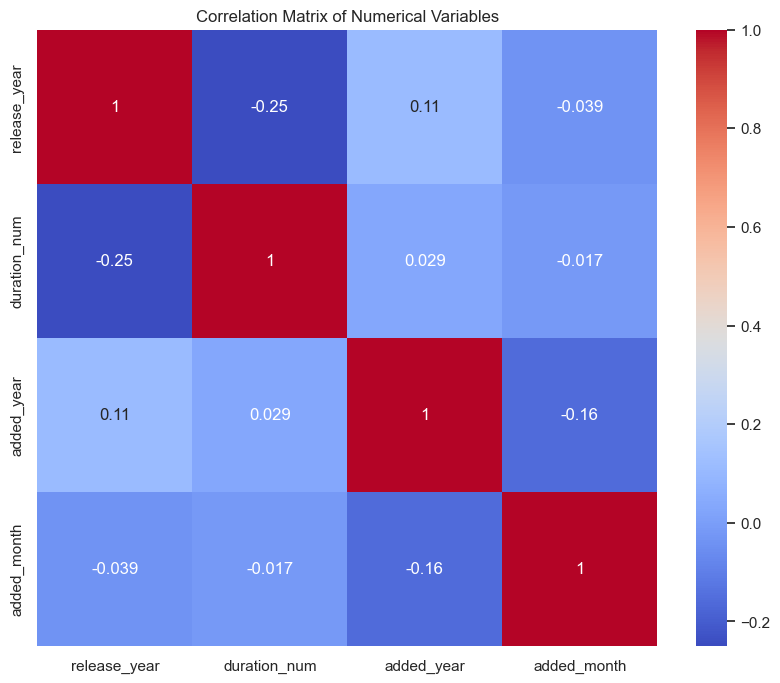

In [65]:
# Correlation analysis
numerical_df = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Modeling Analysis

### 1. Single-Variable Regression

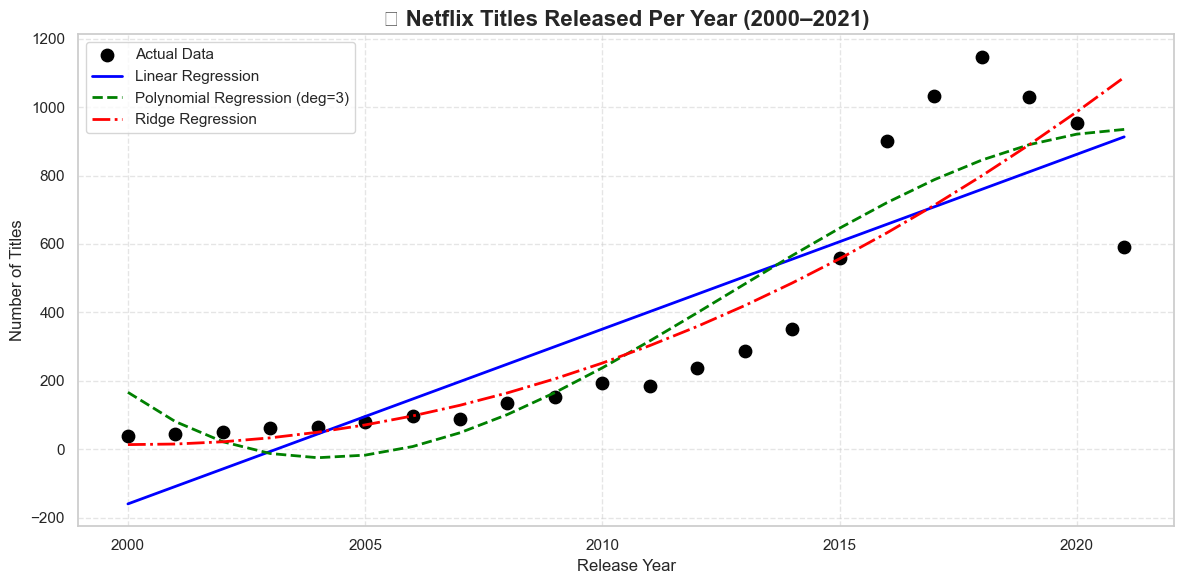

📘 Model Comparison:

🔹 Linear:        R² = 0.7403, Equation: y = 51.10x + -102357.71
🔸 Polynomial:    R² = 0.8366, y = -0.38x³ + 2302.78x² + -4634662.12x + 3109239783.26
🔺 Ridge:         R² = 0.7962, y = 0.00x³ + -2.46x² + -0.03x + 3275199.68


In [74]:
# Clean & prepare the data
df = df.dropna(subset=['release_year'])
year_counts = df['release_year'].value_counts().sort_index()
year_df = pd.DataFrame({'Year': year_counts.index, 'Title_Count': year_counts.values})
year_df = year_df[(year_df['Year'] >= 2000) & (year_df['Year'] <= 2021)]

# Features & target
X = year_df[['Year']]
y = year_df['Title_Count']

# Standardize the feature for Ridge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 1. Linear Regression ---
linear_model = LinearRegression()
linear_model.fit(X, y)
y_linear = linear_model.predict(X)

# --- 2. Polynomial Regression ---
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_poly = poly_model.predict(X_poly)

# --- 3. Ridge Regression (with polynomial features) ---
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_poly, y)
y_ridge = ridge_model.predict(X_poly)

# 🎨 Plotting
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Actual data points
plt.scatter(X, y, color='black', s=80, label='Actual Data')

# Plot models
plt.plot(X, y_linear, color='blue', label='Linear Regression', linewidth=2)
plt.plot(X, y_poly, color='green', linestyle='--', label='Polynomial Regression (deg=3)', linewidth=2)
plt.plot(X, y_ridge, color='red', linestyle='-.', label='Ridge Regression', linewidth=2)

# Titles and labels
plt.title("📊 Netflix Titles Released Per Year (2000–2021)", fontsize=16, fontweight='bold')
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 📈 Print Equations & Scores
from sklearn.metrics import r2_score

print("📘 Model Comparison:\n")

# Linear
print(f"🔹 Linear:        R² = {r2_score(y, y_linear):.4f}, Equation: y = {linear_model.coef_[0]:.2f}x + {linear_model.intercept_:.2f}")

# Polynomial
poly_coeffs = poly_model.coef_
poly_eq = f"y = {poly_coeffs[3]:.2f}x³ + {poly_coeffs[2]:.2f}x² + {poly_coeffs[1]:.2f}x + {poly_model.intercept_:.2f}"
print(f"🔸 Polynomial:    R² = {r2_score(y, y_poly):.4f}, {poly_eq}")

# Ridge
ridge_coeffs = ridge_model.coef_
ridge_eq = f"y = {ridge_coeffs[3]:.2f}x³ + {ridge_coeffs[2]:.2f}x² + {ridge_coeffs[1]:.2f}x + {ridge_model.intercept_:.2f}"
print(f"🔺 Ridge:         R² = {r2_score(y, y_ridge):.4f}, {ridge_eq}")